# Pipeline for the anomaly detection on the SKAB using LSTM-VAE

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
from evaluating import evaluating_change_point

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (1154, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 13241

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.770310,0.382638,71.2129,25.0827,219.789,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027269,0.040226,1.096960,0.710565,71.4284,25.0863,233.117,32.0104,0.0,0.0
2020-03-09 12:14:38,0.027040,0.039773,1.140150,0.054711,71.3468,25.0874,234.745,32.0000,0.0,0.0
2020-03-09 12:14:39,0.027563,0.040313,1.108680,-0.273216,71.3258,25.0897,205.254,32.0104,0.0,0.0
2020-03-09 12:14:41,0.026570,0.039566,0.704404,0.382638,71.2725,25.0831,212.095,33.0000,0.0,0.0


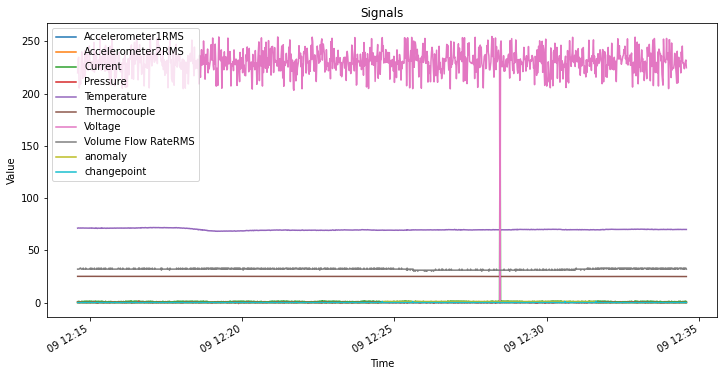

In [5]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

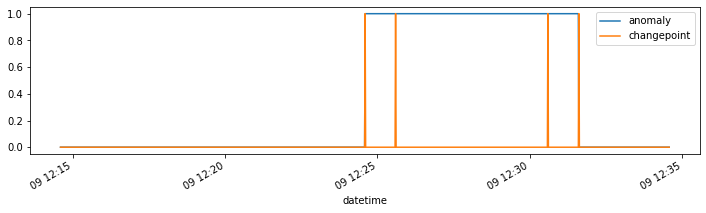

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [7]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np

from scipy.signal import medfilt

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [9]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        mse = losses.MeanSquaredError()
        xent_loss = mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

In [10]:
def arch(data):
    Random(0)
    
    input_dim = data.shape[-1] # 13
    timesteps = data.shape[1] # 3
    BATCH_SIZE = 1
    
    model, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=BATCH_SIZE, 
        intermediate_dim=32,
        latent_dim=100,
        epsilon_std=1.)

    history = model.fit(
        data,
        data,
        epochs=20,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return history, model

### Training in the beginning of each dataset

In [11]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [12]:
# hyperparameters selection
N_STEPS = 5
Q = 0.999 # quantile for upper control limit (UCL) selection

# inference
predicted_outlier, predicted_cp = [], []
for df in tqdm(list_of_df, desc='1st loop'):
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model defining and fitting
    history, model = arch(X)
    
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    UCL = residuals.quantile(Q)
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > (3/2 * UCL)
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

1st loop: 100%|██████████| 34/34 [42:38<00:00, 75.26s/it] 


### Results

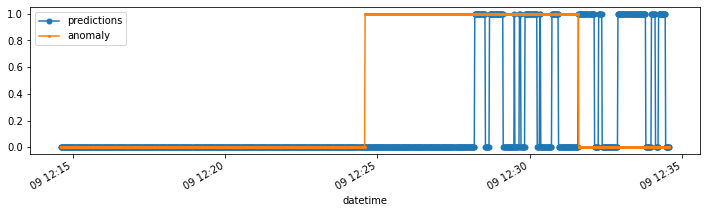

In [13]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

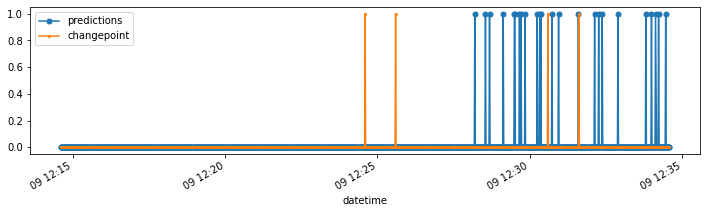

In [14]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [15]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 9.13 %
Missing Alarm Rate 55.03 %
F1 metric 0.56


In [16]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:07.407407407
A number of missed CPs = 103


In [17]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 27
Intersec

## [Additional] localization